# ML Engineering Challenge - Exploratory Data Analysis

You can use this notebook to collect all analysis rolled out on the features and targets.

_Please do not cleanup the output when submitting your solution_


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.config import ZONES, ROOT_PATH


In [ ]:
from sklearn.impute import KNNImputer
def knn_impute_targets(df_feat, df_targ, n_neighbors=5):
    """
    Impute missing values in df_targ using K-Nearest Neighbors (KNN) based on df_feat.

    Parameters:
    - df_feat: DataFrame containing feature data with the same MultiIndex as df_targ.
    - df_targ: DataFrame containing target data with missing values (NaNs) to be imputed.
    - n_neighbors: Number of neighbors to use for KNN imputation.

    Returns:
    - df_targ_filled: DataFrame with the same structure as df_targ, with missing values imputed.
    """
    # Ensure the indexes of df_feat and df_targ align
    if not df_feat.index.equals(df_targ.index):
        raise ValueError("The indexes of df_feat and df_targ must match.")

    # Combine feature and target data
    combined = df_feat.join(df_targ, how='inner')

    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = imputer.fit_transform(combined)

    # Reconstruct the DataFrame with the original index and columns
    combined_imputed = pd.DataFrame(imputed_data, index=combined.index, columns=combined.columns)

    # Extract the imputed target data
    df_targ_filled = combined_imputed[df_targ.columns]

    return df_targ_filled

ZONE US-CAL-CISO Features: (2800, 1847) Targets: (2800, 1) ['power_production_solar_avg'] Nans: 0 Nans target: 0
ZONE US-TEX-ERCO Features: (2800, 2215) Targets: (2800, 1) ['power_production_solar_avg'] Nans: 0 Nans target: 416


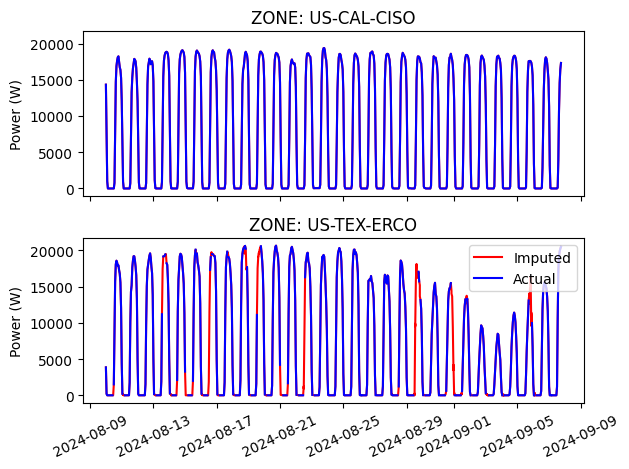

In [66]:
# Visualize target
target = 'power_production_solar_avg'
index = ['target_time', 'horizon']
fig, axes = plt.subplots(ncols=1, nrows=len(ZONES),sharex=True, sharey=True)
for i, zone in enumerate(ZONES):
    df_feat = pd.read_parquet('../data/data/features/'+f"{zone}.parquet")
    df_targ = pd.read_parquet('../data/data/targets/'+f"{zone}.parquet")
    # impute target
    df_targ_ = knn_impute_targets(df_feat, df_targ, n_neighbors=5)

    print(f"ZONE {zone} Features: {df_feat.shape} Targets: {df_targ.shape} {df_targ.columns.to_list()} "
          f"Nans: {df_feat.isnull().sum().sum()} Nans target: {df_targ.isnull().sum().sum()}")

    df_feat.reset_index(inplace=True) # for plotting
    df_targ.reset_index(inplace=True)
    df_targ_.reset_index(inplace=True)
    # print(df_feat.columns.to_list())

    # axes[i].plot(df_targ.index, df_targ['power_production_solar_avg'])
    axes[i].plot(pd.to_datetime(df_targ_['target_time']), df_targ_['power_production_solar_avg'], color='red', label='Imputed')
    axes[i].plot(pd.to_datetime(df_targ['target_time']), df_targ['power_production_solar_avg'], color='blue', label='Actual')
    axes[i].title.set_text(f"ZONE: {zone}")
    axes[i].set_ylabel('Power (W)') # Assuming it is in W...
    if i == len(ZONES) - 1:
        axes[i].legend()
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("../figures/power_production_solar_avg.png")
plt.show()


#### Notes

As expected, `targets` datasets contain one column with the target variable.
`features` datasets, however, contain a large number of features that correspond to different weather variables.
Dataframes have Multiindex with 'target_time', 'horizon'.
> Assumption: data represents weather forecasts made on a date 'target_time' forecasted to 'horizon' hours after that. It is unclear to me how to use this information.

One of the `target` dataframes contains nans. Imputation is required. None of the feature dataframes contain nans though.



ConversionError: Failed to convert value(s) to axis units: array([(Timestamp('2024-08-10 00:00:00+0000', tz='UTC'), 0),
       (Timestamp('2024-08-10 01:00:00+0000', tz='UTC'), 1),
       (Timestamp('2024-08-10 02:00:00+0000', tz='UTC'), 2), ...,
       (Timestamp('2024-09-07 16:00:00+0000', tz='UTC'), 22),
       (Timestamp('2024-09-07 17:00:00+0000', tz='UTC'), 23),
       (Timestamp('2024-09-07 18:00:00+0000', tz='UTC'), 24)],
      dtype=object)

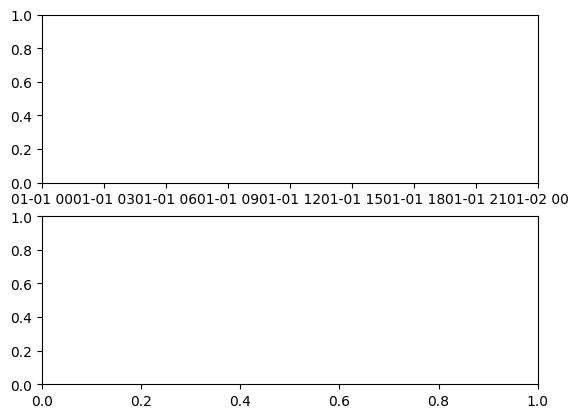

In [61]:
fig, axes = plt.subplots(ncols=1, nrows=len(ZONES))
for i, zone in enumerate(ZONES):
    df_feat = pd.read_parquet('../data/data/features/'+f"{zone}.parquet")
    df_targ = pd.read_parquet('../data/data/targets/'+f"{zone}.parquet")

    axes[i].plot(df_targ.index, df_targ['power_production_solar_avg'])

    df_targ = knn_impute_targets(df_feat, df_targ, n_neighbors=5)

    print(f"ZONE {zone} Features: {df_feat.shape} Targets: {df_targ.shape} {df_targ.columns.to_list()} "
          f"Nans: {df_feat.isnull().sum().sum()} Nans target: {df_targ.isnull().sum().sum()}")

    df_feat.reset_index(inplace=True) # for plotting
    df_targ.reset_index(inplace=True)

    axes[i].plot(df_targ.index, df_targ['power_production_solar_avg'])
plt.show()


### Imputation

I decided to use KNN to impute the time-series since by the nature of this forecasting task -- features are strong predictors of the target. The result also looks good. One can experiment with using simple pandas imputer or a Random Forecast imputer. However time is limited and KNN strikes a good balance between complexity and time-to-implement.



In [ ]:
#